In [1]:
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Input
from keras.layers import MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets.mnist import load_data
from keras.models import load_model
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageOps 
from keras.preprocessing import image

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency 
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):
        # Need to convert to RGBA if LA format due to a bug in PIL 
        alpha = im.convert('RGBA').split()[-1]
        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg
    else:
        return im

test_data = []
train_data = []

for filepath in os.listdir('env_images/'):
    img = Image.open('env_images/'+filepath)
    img = np.array(remove_transparency(img).convert('L'))
    train_data.append(img)
    
# for filepath in os.listdir('env_images/'):
#     img = np.array(Image.open('env_images/'+filepath).convert('L'))
#     train_data.append(img)

for filepath in os.listdir('env_images_test/'):
    img = Image.open('env_images_test/'+filepath)
    img = np.array(remove_transparency(img).convert('L'))
    test_data.append(img)

# for filepath in os.listdir('env_images_test/'):
#     img = np.array(Image.open('env_images_test/'+filepath).convert('L'))
#     test_data.append(img)
    
xtrain = np.array(train_data)
xtest = np.array(test_data)
# print(xtrain.shape)

xtrain = xtrain.astype('float32') / 255
xtest = xtest.astype('float32') / 255 
# print(xtrain.shape)

x_train = np.reshape(xtrain, (len(xtrain), 80, 80, 1)) 
x_test = np.reshape(xtest, (len(xtest), 80, 80, 1)) 
 
print(x_train.shape) 
print(x_test.shape)



(5001, 80, 80, 1)
(101, 80, 80, 1)


In [4]:
class AutoEncoder():
    def __init__(self,x_train,x_test):
        self.x_train = x_train
        self.x_test = x_test
        
    def _encoder(self):
        input_img = Input(shape=(80, 80,1))
        enc_conv1 = Conv2D(12, (3, 3), activation='relu', padding='same')(input_img)
        enc_pool1 = MaxPooling2D((2, 2), padding='same')(enc_conv1)
        enc_conv2 = Conv2D(8, (4, 4), activation='relu', padding='same')(enc_pool1)
        enc_output = MaxPooling2D((4, 4), padding='same')(enc_conv2)
        self.shape = K.int_shape(enc_output)
        model = Model(input_img, enc_output)
        model.summary()
        self.encoder = model
        return model

    def _decoder(self):
        dec_input = Input(shape=(10, 10, 8))   
        dec_conv2 = Conv2DTranspose(8, (4, 4), activation='relu', padding='same')(dec_input)
        t = UpSampling2D((4, 4))(dec_conv2)
        dec_conv3 = Conv2DTranspose(12, (3, 3), activation='relu', padding='same')(t)
        dec_upsample2 = UpSampling2D((2, 2))(dec_conv3)
        dec_output = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(dec_upsample2)
        model = Model(dec_input, dec_output)
        model.summary()
        self.decoder = model
        return model

    def encoder_decoder(self):
        enc = self._encoder()
        dec = self._decoder()
        inputs = Input(shape=(80,80,1))
        enc_out = enc(inputs)
        dec_out = dec(enc_out)
        model = Model(inputs, dec_out)
        model.summary()
        self.model = model
        return model

    def fit(self, batch_size=128, epochs=20):
#         self.model.compile(optimizer='nadam',loss='binary_crossentropy')
        self.model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])
        self.model.fit(self.x_train, self.x_train, epochs=epochs, batch_size=batch_size, validation_data = (x_test,x_test))

    def save_model(self):
        self.encoder.save('./weights/encoder_weights.h5')
        self.decoder.save('./weights/decoder_weights.h5')
        self.model.save('./weights/autoencoder_weights.h5')


In [5]:
ae = AutoEncoder(x_train,x_test)
ae.encoder_decoder()
ae.fit(batch_size=128,epochs=100)
ae.save_model()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 80, 12)        120       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 8)         1544      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 8)         0         
Total params: 1,664
Trainable params: 1,664
Non-trainable params: 0
_________________________________________________________________
Model: "functional_3"
_________________________________________________________________
Layer (type)                 O

40/40 [==============================] - 1s 19ms/step - loss: 2.5106e-04 - accuracy: 0.0000e+00 - val_loss: 9.9691e-04 - val_accuracy: 0.0000e+00
Epoch 36/100
40/40 [==============================] - 1s 19ms/step - loss: 2.3222e-04 - accuracy: 0.0000e+00 - val_loss: 9.3790e-04 - val_accuracy: 0.0000e+00
Epoch 37/100
40/40 [==============================] - 1s 19ms/step - loss: 2.1510e-04 - accuracy: 0.0000e+00 - val_loss: 8.8787e-04 - val_accuracy: 0.0000e+00
Epoch 38/100
40/40 [==============================] - 1s 19ms/step - loss: 2.0061e-04 - accuracy: 0.0000e+00 - val_loss: 8.4904e-04 - val_accuracy: 0.0000e+00
Epoch 39/100
40/40 [==============================] - 1s 19ms/step - loss: 1.8818e-04 - accuracy: 0.0000e+00 - val_loss: 8.1582e-04 - val_accuracy: 0.0000e+00
Epoch 40/100
40/40 [==============================] - 1s 19ms/step - loss: 1.7725e-04 - accuracy: 0.0000e+00 - val_loss: 7.8542e-04 - val_accuracy: 0.0000e+00
Epoch 41/100
40/40 [==============================] - 1s 19

40/40 [==============================] - 1s 19ms/step - loss: 5.7486e-05 - accuracy: 0.0000e+00 - val_loss: 3.4632e-04 - val_accuracy: 0.0000e+00
Epoch 87/100
40/40 [==============================] - 1s 19ms/step - loss: 5.7186e-05 - accuracy: 0.0000e+00 - val_loss: 3.4386e-04 - val_accuracy: 0.0000e+00
Epoch 88/100
40/40 [==============================] - 1s 19ms/step - loss: 5.6579e-05 - accuracy: 0.0000e+00 - val_loss: 3.4151e-04 - val_accuracy: 0.0000e+00
Epoch 89/100
40/40 [==============================] - 1s 19ms/step - loss: 5.6492e-05 - accuracy: 0.0000e+00 - val_loss: 3.4208e-04 - val_accuracy: 0.0000e+00
Epoch 90/100
40/40 [==============================] - 1s 19ms/step - loss: 5.5937e-05 - accuracy: 0.0000e+00 - val_loss: 3.3852e-04 - val_accuracy: 0.0000e+00
Epoch 91/100
40/40 [==============================] - 1s 19ms/step - loss: 5.5307e-05 - accuracy: 0.0000e+00 - val_loss: 3.3697e-04 - val_accuracy: 0.0000e+00
Epoch 92/100
40/40 [==============================] - 1s 19

In [6]:
encoder = load_model('./weights/encoder_weights.h5',compile=False)
decoder = load_model('./weights/decoder_weights.h5',compile=False)

In [19]:

inputs = x_test[50].reshape(1,80,80,1)
x = encoder.predict(inputs)
y = decoder.predict(x)

print(inputs.shape)
print(x.shape)
print(y.shape)

(1, 80, 80, 1)
(1, 10, 10, 8)
(1, 80, 80, 1)


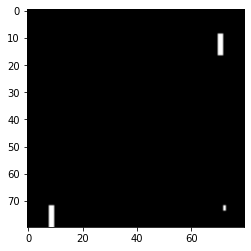

In [20]:
plt.imshow(inputs.reshape(80, 80),cmap='gray')

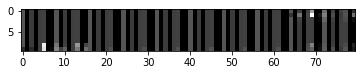

In [21]:
plt.imshow(x.reshape(10,80),cmap='gray')

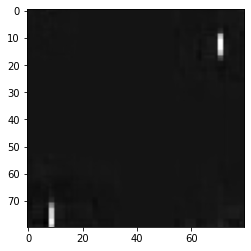

In [22]:
plt.imshow(y.reshape(80, 80),cmap='gray')